In [72]:
import sys
sys.path.append('/home/tom/repos/SelfOrganisingWeddingInvite/SelfOrganisingCollage')

import argparse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from tqdm import tqdm
import torch
from torchvision import models, transforms
import PIL

from photo_library import PhotoLibrary
from SOM import SelfOrganisingMap
from feature_extraction import FeatureExtractor
from draw_samples import sample_from_unit_cube
from patch_worker import Patchworker
from utils import ravel_index, simplify_shape

from pylab import rcParams
rcParams['figure.figsize'] = 10, 20

args = lambda: None
args.directory = '/home/tom/Pictures/test_pics'
args.height = 35
args.width = 50
args.feature = 'mean_color'
args.epochs = 20
args.reuse_penalty = 100.
args.sample_size = 1000
args.border = 20
args.magnify = 20

In [3]:
library = PhotoLibrary(args.directory)
extractor = FeatureExtractor.factory(args.feature)

try:
    with open(os.path.join(args.directory, args.feature), "rb") as f:
        feature_dict = pickle.load(f)

except FileNotFoundError:
    feature_dict = extractor.process_library(library)
    with open(os.path.join(args.directory, args.feature), "wb") as f:
        pickle.dump(feature_dict, f)

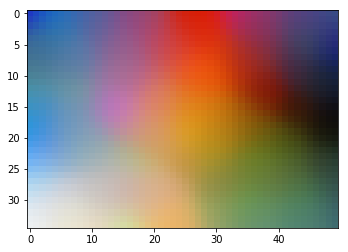

In [4]:
som = SelfOrganisingMap(shape=[args.height, args.width, extractor.feature_dim], sigma=5., eta=1.)

# draw a subset of just the most interesting the entire photo library
sample, keys = sample_from_unit_cube(feature_dict, args.sample_size)

for _ in range(args.epochs):
    for feature in sample[torch.randperm(args.sample_size),:]:
        som.update(feature.cuda())
        
plt.imshow(som.grid)

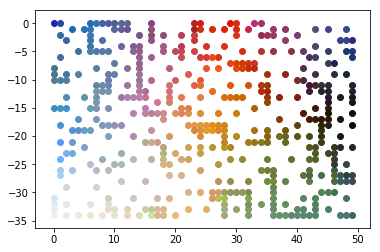

In [5]:
patch = Patchworker([args.height, args.width])

# now find the best vibing photo and stick it at its BMU
times_used = torch.zeros(len(sample)).unsqueeze(1).cuda()
layout = []

# I can omit the occupied parts of the grid to speed this up
while not patch.full():
    dist = (sample.cuda().unsqueeze(1) - som.grid.reshape(-1,3).unsqueeze(0)).norm(dim=2)
    dist += (times_used * args.reuse_penalty) # penalise the samples that have already been placed on the grid
    dist[:, patch.occupied.reshape(-1)] = dist.max() # omit any neurons that already have a photo covering them

    # find the neuron and sample that match most closely
    winning_sample, winning_neuron = ravel_index(dist.argmin(), (som.grid.shape[0] * som.grid.shape[1]))
    target_coord = torch.Tensor(ravel_index(winning_neuron, som.grid.shape[1]))
    target_shape = simplify_shape(library[keys[winning_sample]].size)

    # add the photo to the patch work
    coord, shape = patch.add_patch(target_coord, target_shape)

    layout.append([keys[winning_sample], coord, shape, sample[winning_sample]])

    times_used[winning_sample] += 1

for key, coord, shape, feature in layout:
    plt.scatter(coord[1], -coord[0], c=feature.numpy()[None,:])

plt.show()

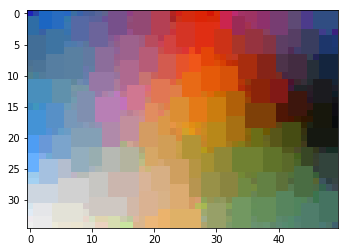

In [6]:
patchwork = torch.zeros([args.height, args.width, 3])

for key, coord, shape, feature in layout:
    tl = coord - shape / 2
    br = tl + shape

    patchwork[tl[0]:br[0],tl[1]:br[1],:] = feature

plt.imshow(patchwork)

In [42]:
np.array([((centroid - shape / 2) * args.magnify).numpy() for (key, centroid, shape, feature) in layout]).min(axis=0)

array([0, 0], dtype=int32)

In [ ]:
canvas = PIL.Image.new("RGB", tuple(np.array(som.grid.shape[:2]) * args.magnify + args.border), "white")

for i, (key, centroid, shape, feature) in enumerate(layout):
    img = library[key]

    size = shape.numpy() * args.magnify
    corner = (centroid - shape / 2).numpy() * args.magnify
    
    target_aspect = size[0] / size[1]
    img_aspect = img.size[0] / img.size[1]
    
    if target_aspect < img_aspect:
        crop_size = (img.size[1], img.size[1] * target_aspect)
    else:
        crop_size = (img.size[0] / target_aspect, img.size[0])

    crop = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize((size[1], size[0]))
    ])

    canvas.paste(crop(img), tuple(corner.astype(np.int)))

plt.imshow(canvas)

canvas.save('invite.png')